# 사전 준비 

##데이터 호출 

In [ ]:
!unzip /content/drive/MyDrive/DataSet/작물병해/data.zip

Archive:  /content/drive/MyDrive/DataSet/작물병해/data.zip
  inflating: sample_submission.csv   
  inflating: test.zip                
  inflating: train.csv               
  inflating: train.zip               


In [ ]:
!unzip train.zip

## 모듈 임포트

In [ ]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt 
import os
import cv2 
from glob import glob
from tqdm import tqdm
import json

In [ ]:
from tensorflow.keras import Sequential
from tensorflow.keras import optimizers
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import Activation
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Input
from tensorflow.keras import Model
from tensorflow.keras.layers import concatenate
from tensorflow.keras.applications import resnet50, efficientnet
from tensorflow.keras.applications import ResNet50, EfficientNetB0
from tensorflow.keras.layers import Bidirectional, LSTM, GRU

# 데이터 로드

## 디렉토리 로드

In [ ]:
train_csv = sorted(glob('train/*/*.csv'))
train_jpg = sorted(glob('train/*/*.jpg'))
train_json = sorted(glob('train/*/*.json'))

## json 파일 로드

In [ ]:
crops = []
diseases = []
risks = []
labels = []

for i in range(len(train_json)):
    with open(train_json[i], 'r') as f:
        sample = json.load(f)
        crop = sample['annotations']['crop']
        disease = sample['annotations']['disease']
        risk = sample['annotations']['risk']
        label=f"{crop}_{disease}_{risk}"
    
        crops.append(crop)
        diseases.append(disease)
        risks.append(risk)
        labels.append(label)
        
label_unique = sorted(np.unique(labels))
label_unique = {key:value for key,value in zip(label_unique, range(len(label_unique)))}

labels = [label_unique[k] for k in labels]

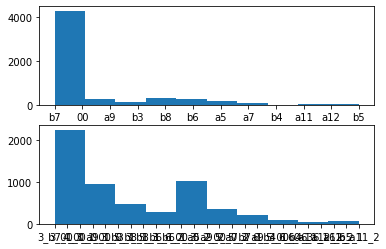

In [ ]:
plt.subplot(2,1,1)
plt.hist(diseases)
plt.subplot(2,1,2)
plt.hist(labels)
plt.show()

In [ ]:
len(set(labels))

25

## 이미지 로드 

In [ ]:
def img_load(path):
    img = cv2.imread(path)
    img = cv2.resize(img, (224, 224))
    return img

imgs = [img_load(k) for k in tqdm(train_jpg)]

100%|██████████| 5767/5767 [00:35<00:00, 162.39it/s]


In [ ]:
csv_features = ['내부 온도 1 평균', '내부 온도 1 최고', '내부 온도 1 최저', '내부 습도 1 평균', '내부 습도 1 최고', 
               '내부 습도 1 최저', '내부 이슬점 평균', '내부 이슬점 최고', '내부 이슬점 최저']

In [ ]:
def csv_load(path):
    temp = pd.read_csv(path)
    temp = np.array(temp[csv_features])
    try:
      temp = temp.astype(float)
    except:
      temp[temp=='-']=0.
      temp = temp.astype(float)
    temp = cv2.resize(temp, dsize = (9,294))
    return temp

csvs = [csv_load(k) for k in tqdm(train_csv)]
csvs = np.array(csvs)

100%|██████████| 5767/5767 [00:38<00:00, 151.45it/s]


In [ ]:
csvs.shape

(5767, 294, 9)

# 전처리 

## Augmentation

이미지

In [ ]:
def rotate_img(img, degree):
  if degree == 90:
    return_img = cv2.rotate(img,cv2.ROTATE_90_CLOCKWISE)
  if degree == 180:
    return_img = cv2.rotate(img, cv2.ROTATE_180)
  if degree == 270:
    return_img = cv2.rotate(img, cv2.ROTATE_90_COUNTERCLOCKWISE)
  return return_img

In [ ]:
imgs_90 = [rotate_img(k,90) for k in tqdm(imgs)]
imgs_180 = [rotate_img(k,180) for k in tqdm(imgs)]
imgs_270 = [rotate_img(k,270) for k in tqdm(imgs)]

100%|██████████| 5767/5767 [00:00<00:00, 6704.52it/s]


In [ ]:
augmented_imgs = np.concatenate([imgs,imgs_90,imgs_180,imgs_270])
augmented_csvs = np.concatenate([csvs,csvs,csvs,csvs])
augmented_labels = np.concatenate([labels,labels,labels,labels])

In [ ]:
print(augmented_imgs.shape,augmented_csvs.shape,augmented_labels.shape)

(23068, 224, 224, 3) (23068, 294, 9) (23068,)


In [ ]:
del imgs, imgs_180, imgs_270, imgs_90, csvs, labels #메모리 관리 

## 믹싱

In [ ]:
index = np.arange(len(augmented_imgs))
np.random.shuffle(index)

In [ ]:
augmented_labels = augmented_labels[index]
augmented_csvs = augmented_csvs[index]
augmented_imgs = augmented_imgs[index]

In [ ]:
augmented_imgs = efficientnet.preprocess_input(augmented_imgs)

In [ ]:
print(augmented_imgs.shape,augmented_csvs.shape,augmented_labels.shape)

(23068, 224, 224, 3) (23068, 294, 9) (23068,)


## 트레인 - 테스트 분할

In [ ]:
index = int(len(augmented_csvs)*0.8)
train_imgs = augmented_imgs[:index]
test_imgs = augmented_imgs[index:]

train_csvs = augmented_csvs[:index]
test_csvs = augmented_csvs[index:]

train_labels = augmented_labels[:index]
test_labels = augmented_labels[index:]

In [ ]:
print(train_imgs.shape, train_csvs.shape, train_labels.shape)

(18454, 224, 224, 3) (18454, 294, 9) (18454,)


# 모델링

## 모델 

In [ ]:
conv_layers = EfficientNetB0(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
conv_layers.trainable = False

16719872/16705208 [==============================] - 0s 0us/step


In [ ]:
#Env 데이터 파트 
Env_input = Input((294,9)) #<---- shape 
x = Bidirectional(LSTM(128,return_sequences= True))(Env_input) #bidirec
x = Bidirectional(LSTM(128))(x)
x = Flatten()(x)
x = BatchNormalization()(x)
x = Dense(64, activation ='relu')(x)
x = BatchNormalization()(x)
x = Dense(32, activation ='relu')(x)
x = BatchNormalization()(x)
Env_output = Dense(10 ,activation='linear')(x)

#iamge 데이터 파트 
image_input = Input((224,224,3))
x = conv_layers(image_input)
x = Flatten()(x)
x = BatchNormalization()(x)
x = Dense(64, activation='relu')(x)
x = BatchNormalization()(x)
x = Dense(32, activation='relu')(x)
x = BatchNormalization()(x)
image_output = Dense(10, activation='linear')(x)

#헤드 결합 
combined_input = concatenate([Env_output,image_output])
x= Dense(64, activation = 'relu')(combined_input) #<--- Dense 
x = BatchNormalization()(x)
x= Dense(32, activation = 'relu')(x) #<--- Dense 
x = BatchNormalization()(x)
output = Dense(25,activation = 'softmax')(x)

label_model = Model([Env_input,image_input],output)

#모델 설계 구조 
import tensorflow 
tensorflow.keras.utils.plot_model(label_model)

NameError: ignored

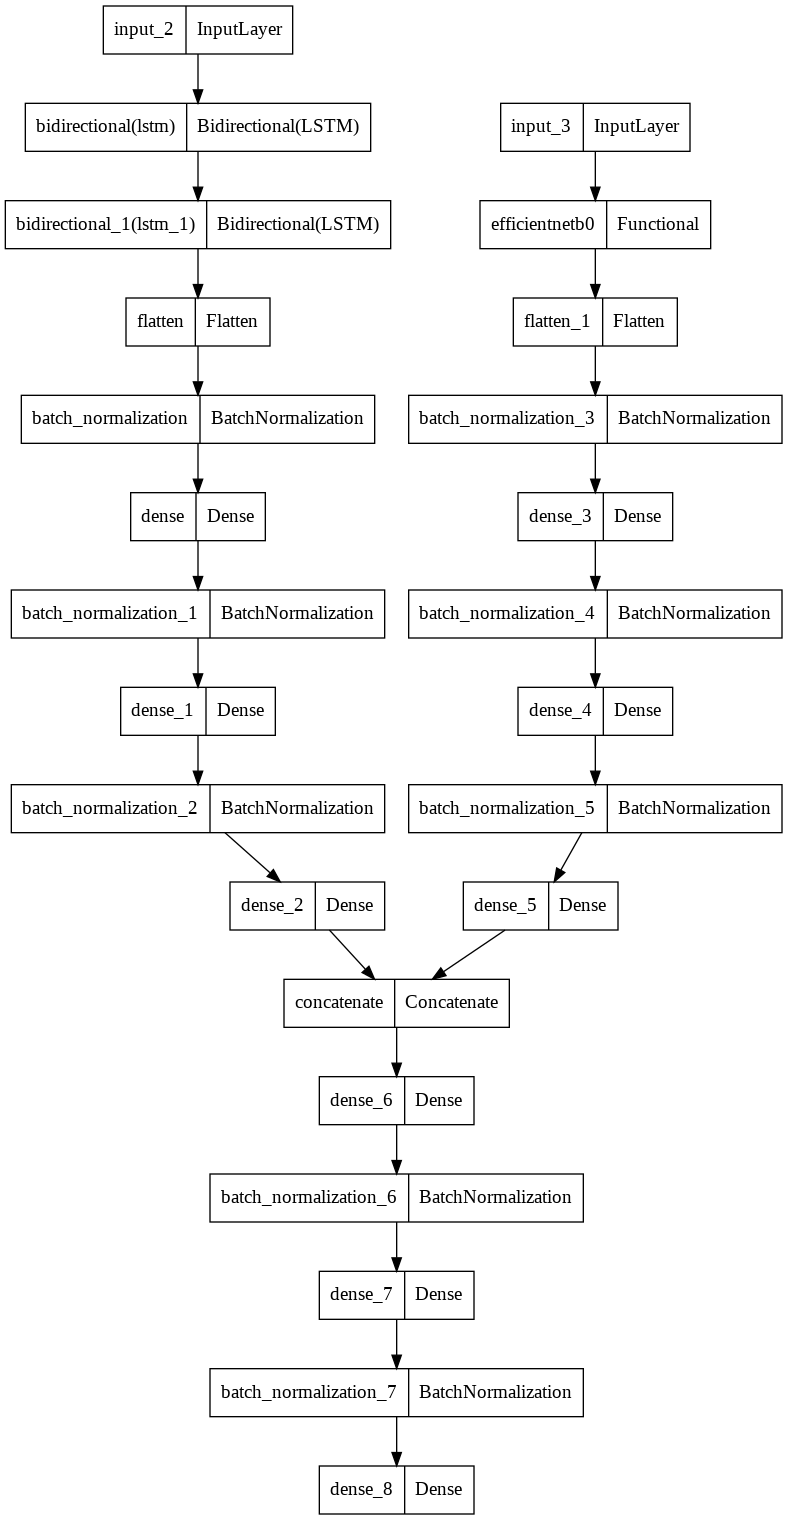

In [ ]:
#모델 설계 구조 
import tensorflow 
tensorflow.keras.utils.plot_model(label_model)

In [ ]:
#optimizer leraning rate 조절 
adam = optimizers.Adam(learning_rate = 0.0005)

In [ ]:
#학습 방식은 동일 
label_model.compile(optimizer=adam, loss="sparse_categorical_crossentropy",metrics = ['accuracy'],)
label_model.summary() #optimizer tuning

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 294, 9)]     0           []                               
                                                                                                  
 bidirectional (Bidirectional)  (None, 294, 256)     141312      ['input_2[0][0]']                
                                                                                                  
 input_3 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 bidirectional_1 (Bidirectional  (None, 256)         394240      ['bidirectional[0][0]']      

In [ ]:
# copy from https://gist.github.com/stared/dfb4dfaf6d9a8501cd1cc8b8cb806d2e
# loss 실시간 출력 
from IPython.display import clear_output
from tensorflow.keras.callbacks import Callback

class PlotLosses(Callback):

  def on_train_begin(self, logs={}):
    self.epochs = []
    self.losses = []
    self.val_losses = []
    self.logs = []
    self.fig = plt.figure()


  def on_epoch_end(self, epoch, logs={}):

    self.epochs.append(epoch)
    self.losses.append(logs.get('loss'))
    self.val_losses.append(logs.get('val_loss'))

    clear_output(wait=True)
    plt.plot(self.epochs, self.losses, label="loss")
    plt.plot(self.epochs, self.val_losses, label="val_loss")
    plt.legend()
    plt.show();
    print("loss = ", self.losses[-1], ", val_loss = ", self.val_losses[-1])

#call backs 선언
plot_losses = PlotLosses()

from tensorflow.keras.callbacks import ModelCheckpoint #<- model 저장 객체, best_model.h5라는 모델 이 저장 됨 
model_check_point = ModelCheckpoint(
    'best_model.h5', 
    monitor='val_loss', 
    verbose=1, 
    save_best_only=True)


from tensorflow.keras.callbacks import EarlyStopping
early_stopping = EarlyStopping(
    monitor='val_loss',  # 모니터링 대상, 이걸 기준으로 멈춤 
    verbose=1,
    patience=50)         # 중지까지의 여유분

from tensorflow.keras.callbacks import ReduceLROnPlateau
reduce_lr = ReduceLROnPlateau(
    monitor='val_loss', # 모니터링 대상
    patience=25,        # 대상ㅃ 기간동안 유지
    factor=0.2,         # 줄이는 양                              
    min_learning_rate=0.00001)     # 최소 학습율

callbacks = [model_check_point, plot_losses, early_stopping, reduce_lr]

## 학습

adam lr 0.0005 + lstm stacked 로 한 경우 18

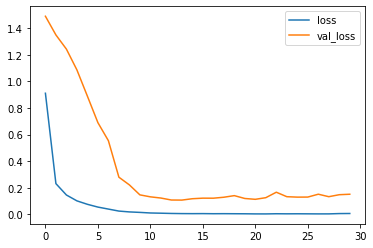

loss =  0.005790351890027523 , val_loss =  0.15083400905132294
58/58 [==============================] - 26s 452ms/step - loss: 0.0058 - accuracy: 0.9991 - val_loss: 0.1508 - val_accuracy: 0.9613


In [ ]:
history = label_model.fit([train_csvs,train_imgs],train_labels, epochs=30, verbose=1, batch_size=256, validation_split=0.2,callbacks=callbacks)

## 자체 예측 스코어

adam lr 0.0005로 조정한 경우

In [ ]:
y_ = label_model.predict([test_csvs,test_imgs])
predicted = np.argmax(y_,axis=1)
predicted - test_labels

array([0, 0, 0, ..., 0, 0, 0])

In [ ]:
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(test_labels, predicted)
print(cm)

In [ ]:
print(classification_report(test_labels, predicted, target_names=['0','1','2','3','4','5','6','7','8','9','10','11','12','13','14','15','16','17','18','19','20','21','22','23','24']))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       636
           1       0.99      1.00      1.00       112
           2       1.00      0.99      1.00       158
           3       1.00      1.00      1.00       924
           4       0.59      0.69      0.64       119
           5       0.52      0.55      0.53       100
           6       0.29      0.10      0.15        39
           7       1.00      0.92      0.96       130
           8       0.80      0.81      0.81       118
           9       1.00      0.99      1.00       125
          10       0.81      0.89      0.85       106
          11       1.00      1.00      1.00       764
          12       1.00      1.00      1.00        45
          13       1.00      1.00      1.00        73
          14       0.92      0.94      0.93       143
          15       1.00      1.00      1.00       106
          16       0.89      0.87      0.88       123
          17       1.00    

# submission 

## 데이터 로드 및 학습 

In [ ]:
!unzip test.zip

In [ ]:
test_csv = sorted(glob('test/*/*.csv'))
test_jpg = sorted(glob('test/*/*.jpg'))

In [ ]:
i = 10381
pred_csv_1 = np.array(test_csv[:i])
pred_jpg_1 = np.array(test_jpg[:i])

pred_csv_2 = np.array(test_csv[i:i*2])
pred_jpg_2 = np.array(test_jpg[i:i*2])

pred_csv_3 = np.array(test_csv[i*2:i*3])
pred_jpg_3 = np.array(test_jpg[i*2:i*3])

pred_csv_4 = np.array(test_csv[i*3:i*4])
pred_jpg_4 = np.array(test_jpg[i*3:i*4])

pred_csv_5 = np.array(test_csv[i*4:])
pred_jpg_5 = np.array(test_jpg[i*4:])

In [ ]:
print(pred_csv_1.shape,pred_csv_2.shape,pred_csv_3.shape,pred_csv_4.shape,pred_csv_5.shape)

(10381,) (10381,) (10381,) (10381,) (10382,)


사전 설정

In [ ]:
csv_features

['내부 온도 1 평균',
 '내부 온도 1 최고',
 '내부 온도 1 최저',
 '내부 습도 1 평균',
 '내부 습도 1 최고',
 '내부 습도 1 최저',
 '내부 이슬점 평균',
 '내부 이슬점 최고',
 '내부 이슬점 최저']

In [ ]:
#이미지 파일 로드 
for i in range(1,6):
  exec(f'jpg_source = pred_jpg_{i}')
  exec(f'csv_source = pred_csv_{i}')

  def img_load(path):
      img = cv2.imread(path)[:,:,::-1]
      img = cv2.resize(img, (224, 224))
      return img

  pred_jpgs = [img_load(k) for k in tqdm(jpg_source)]
  pred_jpgs = np.array(pred_jpgs)
  pred_jpgs = efficientnet.preprocess_input(pred_jpgs)

  #csv 파일 로드 

  def csv_load(path):
      temp = pd.read_csv(path)
      temp = np.array(temp[csv_features])
      try:
        temp = temp.astype(float)
      except:
        temp[temp=='-']=0.
        temp = temp.astype(float)
      temp = cv2.resize(temp, dsize = (9,294))
      return temp

  pred_csvs = [csv_load(k) for k in tqdm(csv_source)]
  pred_csvs = np.array(pred_csvs)

  #학습 

  y_1 = label_model.predict([pred_csvs,pred_jpgs])
  predicted_label = np.argmax(y_1,axis=1)

  print(i)
  exec(f'a_{i} = predicted_label')

100%|██████████| 10381/10381 [01:11<00:00, 145.30it/s]


1


100%|██████████| 10381/10381 [01:12<00:00, 142.79it/s]


2


100%|██████████| 10381/10381 [01:13<00:00, 141.12it/s]


3


100%|██████████| 10381/10381 [01:13<00:00, 141.48it/s]


4


100%|██████████| 10382/10382 [01:12<00:00, 143.59it/s]


5


In [ ]:
pred_csvs.shape

(10381, 294, 9)

In [ ]:
print(a_1.shape,a_2.shape,a_3.shape,a_4.shape,a_5.shape)

## 라벨 디코더 

In [ ]:
crops = []
diseases = []
risks = []
labels = []

for i in range(len(train_json)):
    with open(train_json[i], 'r') as f:
        sample = json.load(f)
        crop = sample['annotations']['crop']
        disease = sample['annotations']['disease']
        risk = sample['annotations']['risk']
        label=f"{crop}_{disease}_{risk}"
    
        crops.append(crop)
        diseases.append(disease)
        risks.append(risk)
        labels.append(label)
        
label_decoding = sorted(np.unique(labels))
label_decoding = {value:key for key,value in zip(label_decoding, range(len(label_decoding)))}

## submission

In [ ]:
submission = pd.read_csv('/content/sample_submission.csv')

In [ ]:
i=10381
submission['label'][:i] =a_1
submission['label'][i:i*2] = a_2
submission['label'][i*2:i*3] = a_3
submission['label'][i*3:i*4] = a_4
submission['label'][i*4:] = a_5

In [ ]:
submission['label'] = submission['label'].apply(lambda x:label_decoding[x])

In [ ]:
submission.head()

,image,label
0,10000,6_00_0
1,10001,5_b6_1
2,10002,4_00_0
3,10003,3_00_0
4,10004,3_b8_1


In [ ]:
submission.to_csv('submission4.csv',index=False)

In [ ]:
!cp submission4.csv /content/drive/MyDrive/모델